<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [2]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [3]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [4]:
economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [5]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매


In [7]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [8]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [9]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

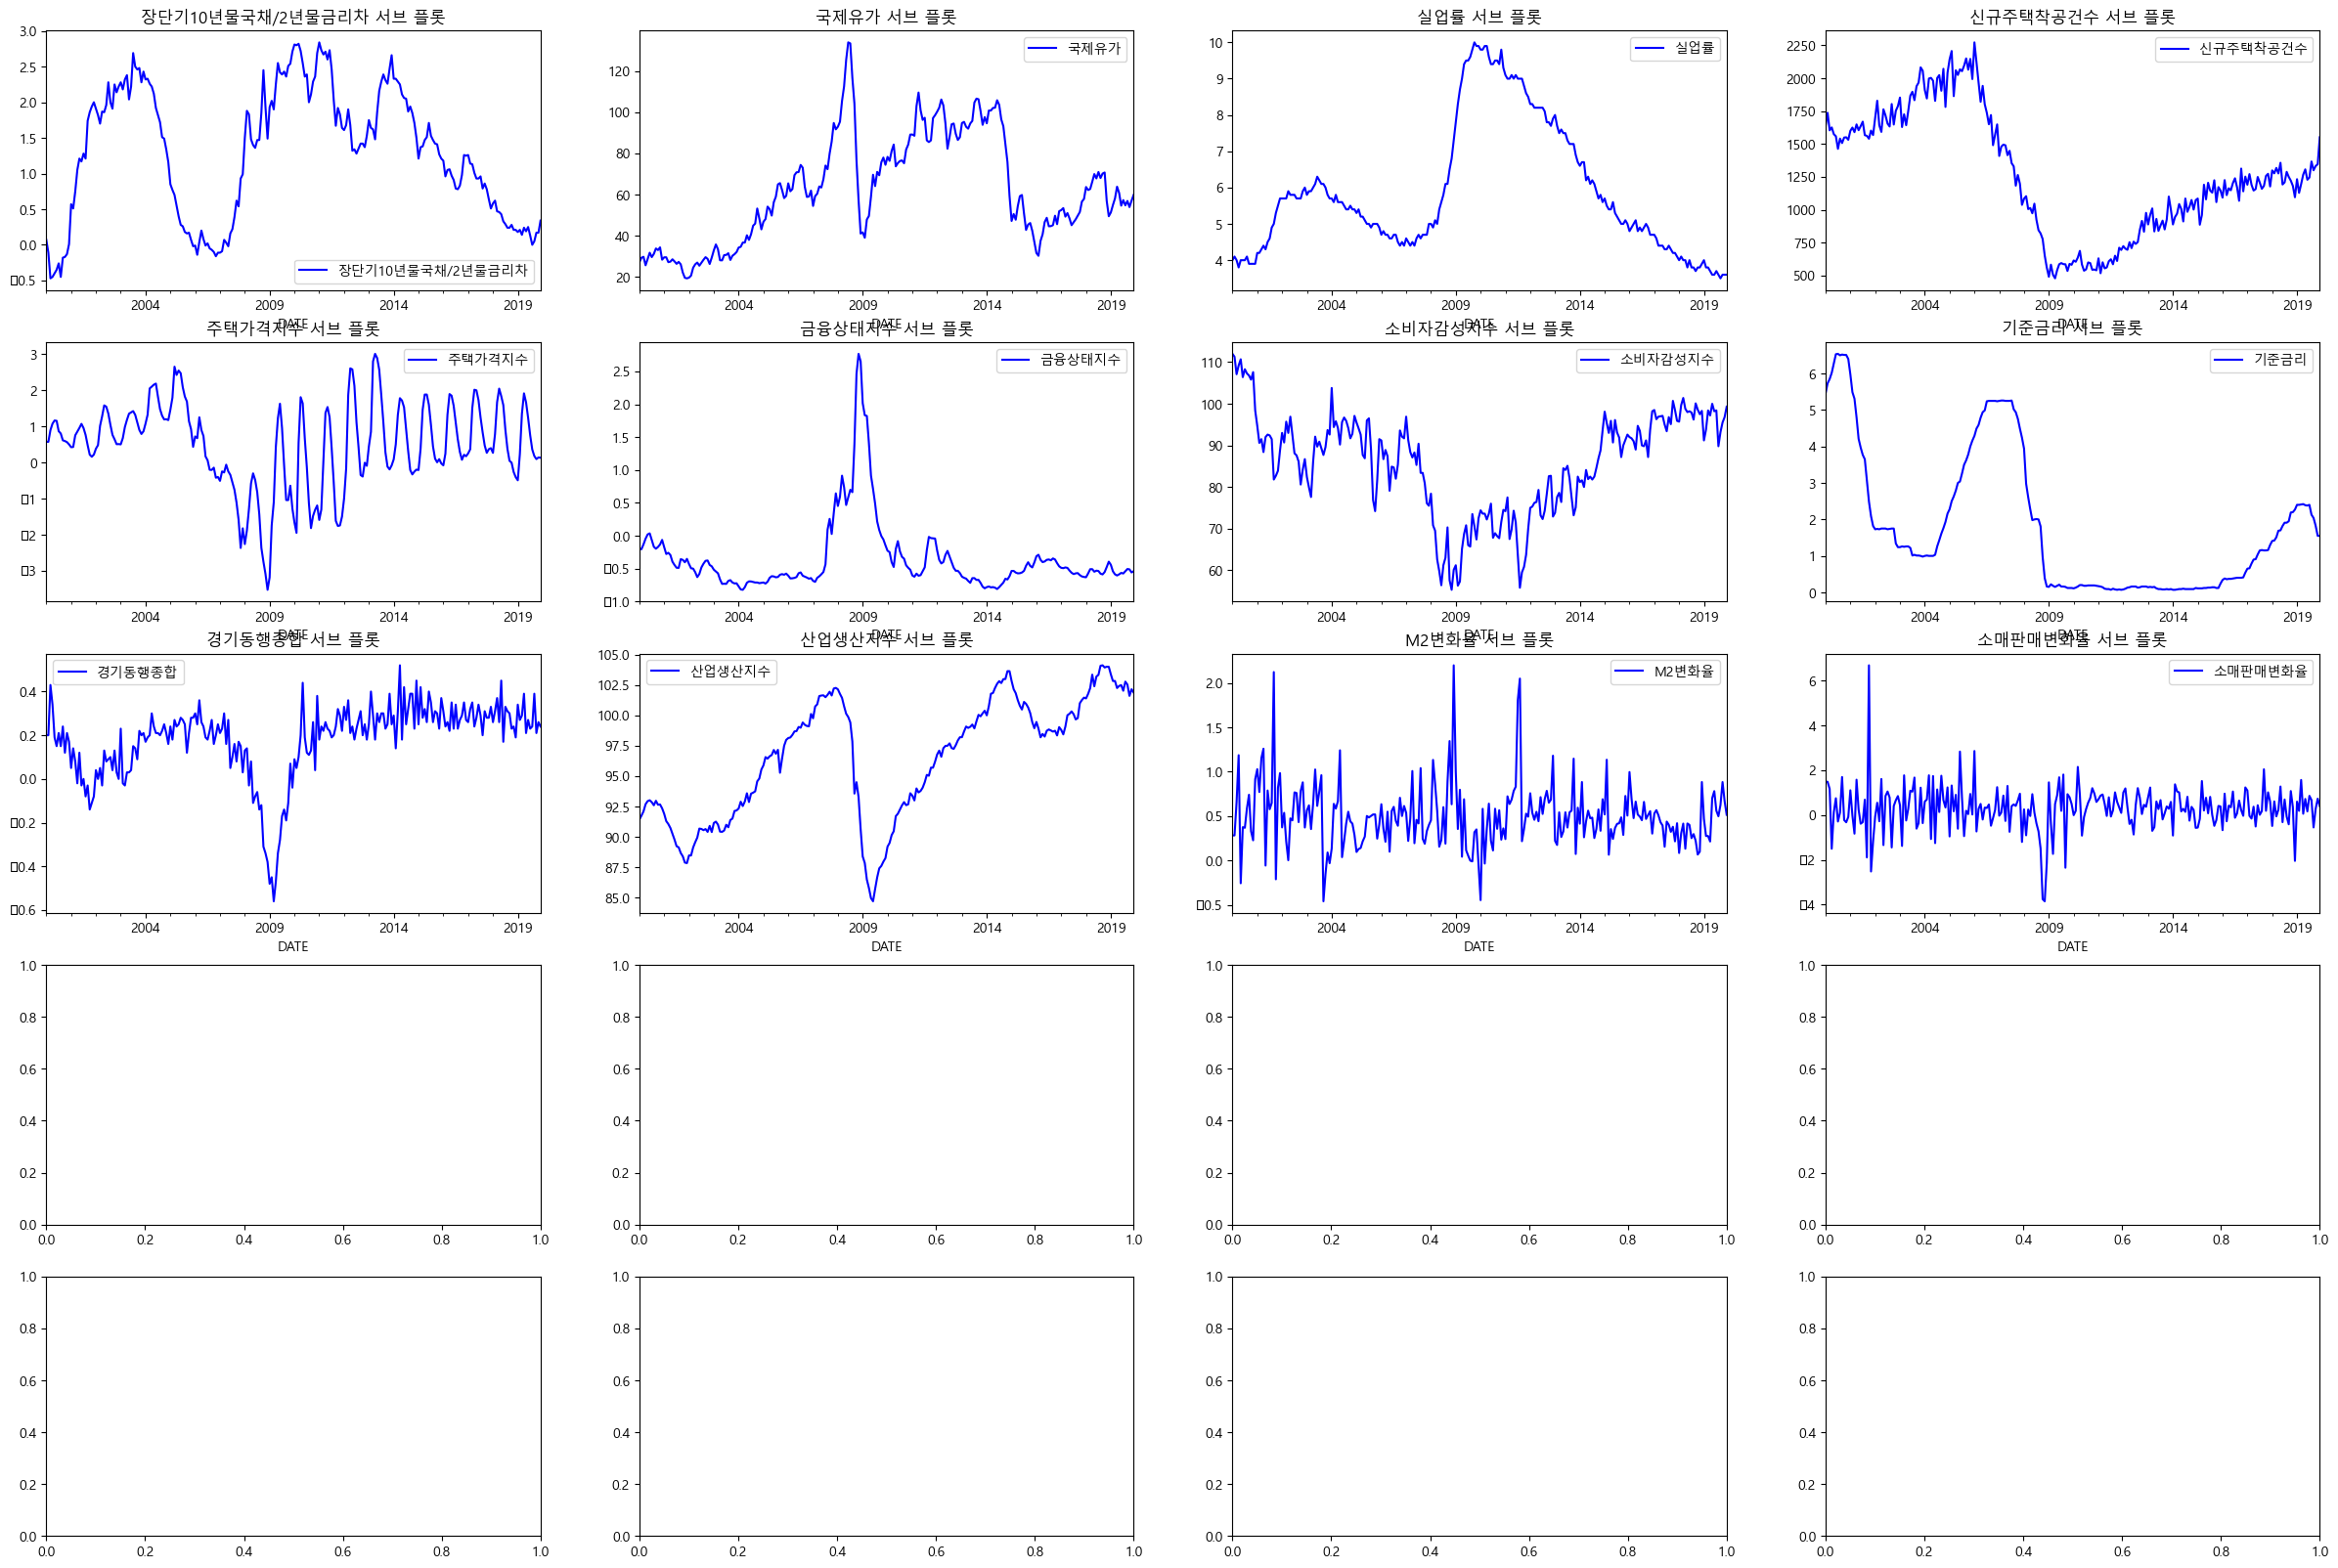

In [10]:
# 그래프 크기 조정
plt.rcParams['font.family'] ='Malgun Gothic'
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()


#### 스케일링

1. min-max : 0~1까지인데 이건 시간적으로 상승하는데이터는
좋지 않아보임

2. StandardScaler

In [11]:
# # scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
# from sklearn.preprocessing import StandardScaler
# # StandardScaler 객체를 생성합니다.
# standard_scaler = StandardScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# scaled_eocs = standard_scaler.fit_transform(economics)
# # 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
# scaled_eocs = pd.DataFrame(scaled_eocs,
#                               index=economics.index,
#                               columns=economics.columns)
# # 표준화가 잘 되었는지 데이터를 확인해봅시다.
# scaled_eocs.head()

In [12]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [13]:
mMscaled_data

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,
2000-01-31,0.163142,0.068739,0.076923,0.645125,0.627085,0.175077,1.000000,0.831530,0.703704,0.346574,0.279060,0.506405
2000-02-29,0.108761,0.087142,0.092308,0.701393,0.627085,0.172010,0.987654,0.874807,0.703704,0.362563,0.279060,0.506405
2000-03-31,0.000000,0.091300,0.076923,0.627298,0.676664,0.192640,0.913580,0.893354,0.916667,0.380972,0.420244,0.476300
2000-04-30,0.006042,0.055314,0.046154,0.639554,0.704055,0.216616,0.950617,0.919629,0.833333,0.411371,0.619081,0.222681
2000-05-31,0.021148,0.082094,0.076923,0.611142,0.717521,0.234737,0.977072,0.958269,0.694444,0.424436,0.076356,0.377830
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.141994,0.309343,0.015385,0.495265,0.594644,0.078896,0.608466,0.318393,0.740741,0.930879,0.360217,0.429159
2019-09-30,0.157100,0.328043,0.000000,0.457939,0.566947,0.088096,0.668430,0.304482,0.879630,0.918323,0.408469,0.313010
2019-10-31,0.193353,0.301980,0.015385,0.475766,0.553940,0.086702,0.708995,0.272025,0.712963,0.870483,0.505253,0.391452


In [14]:
scale_2 =mMscaled_data.copy()

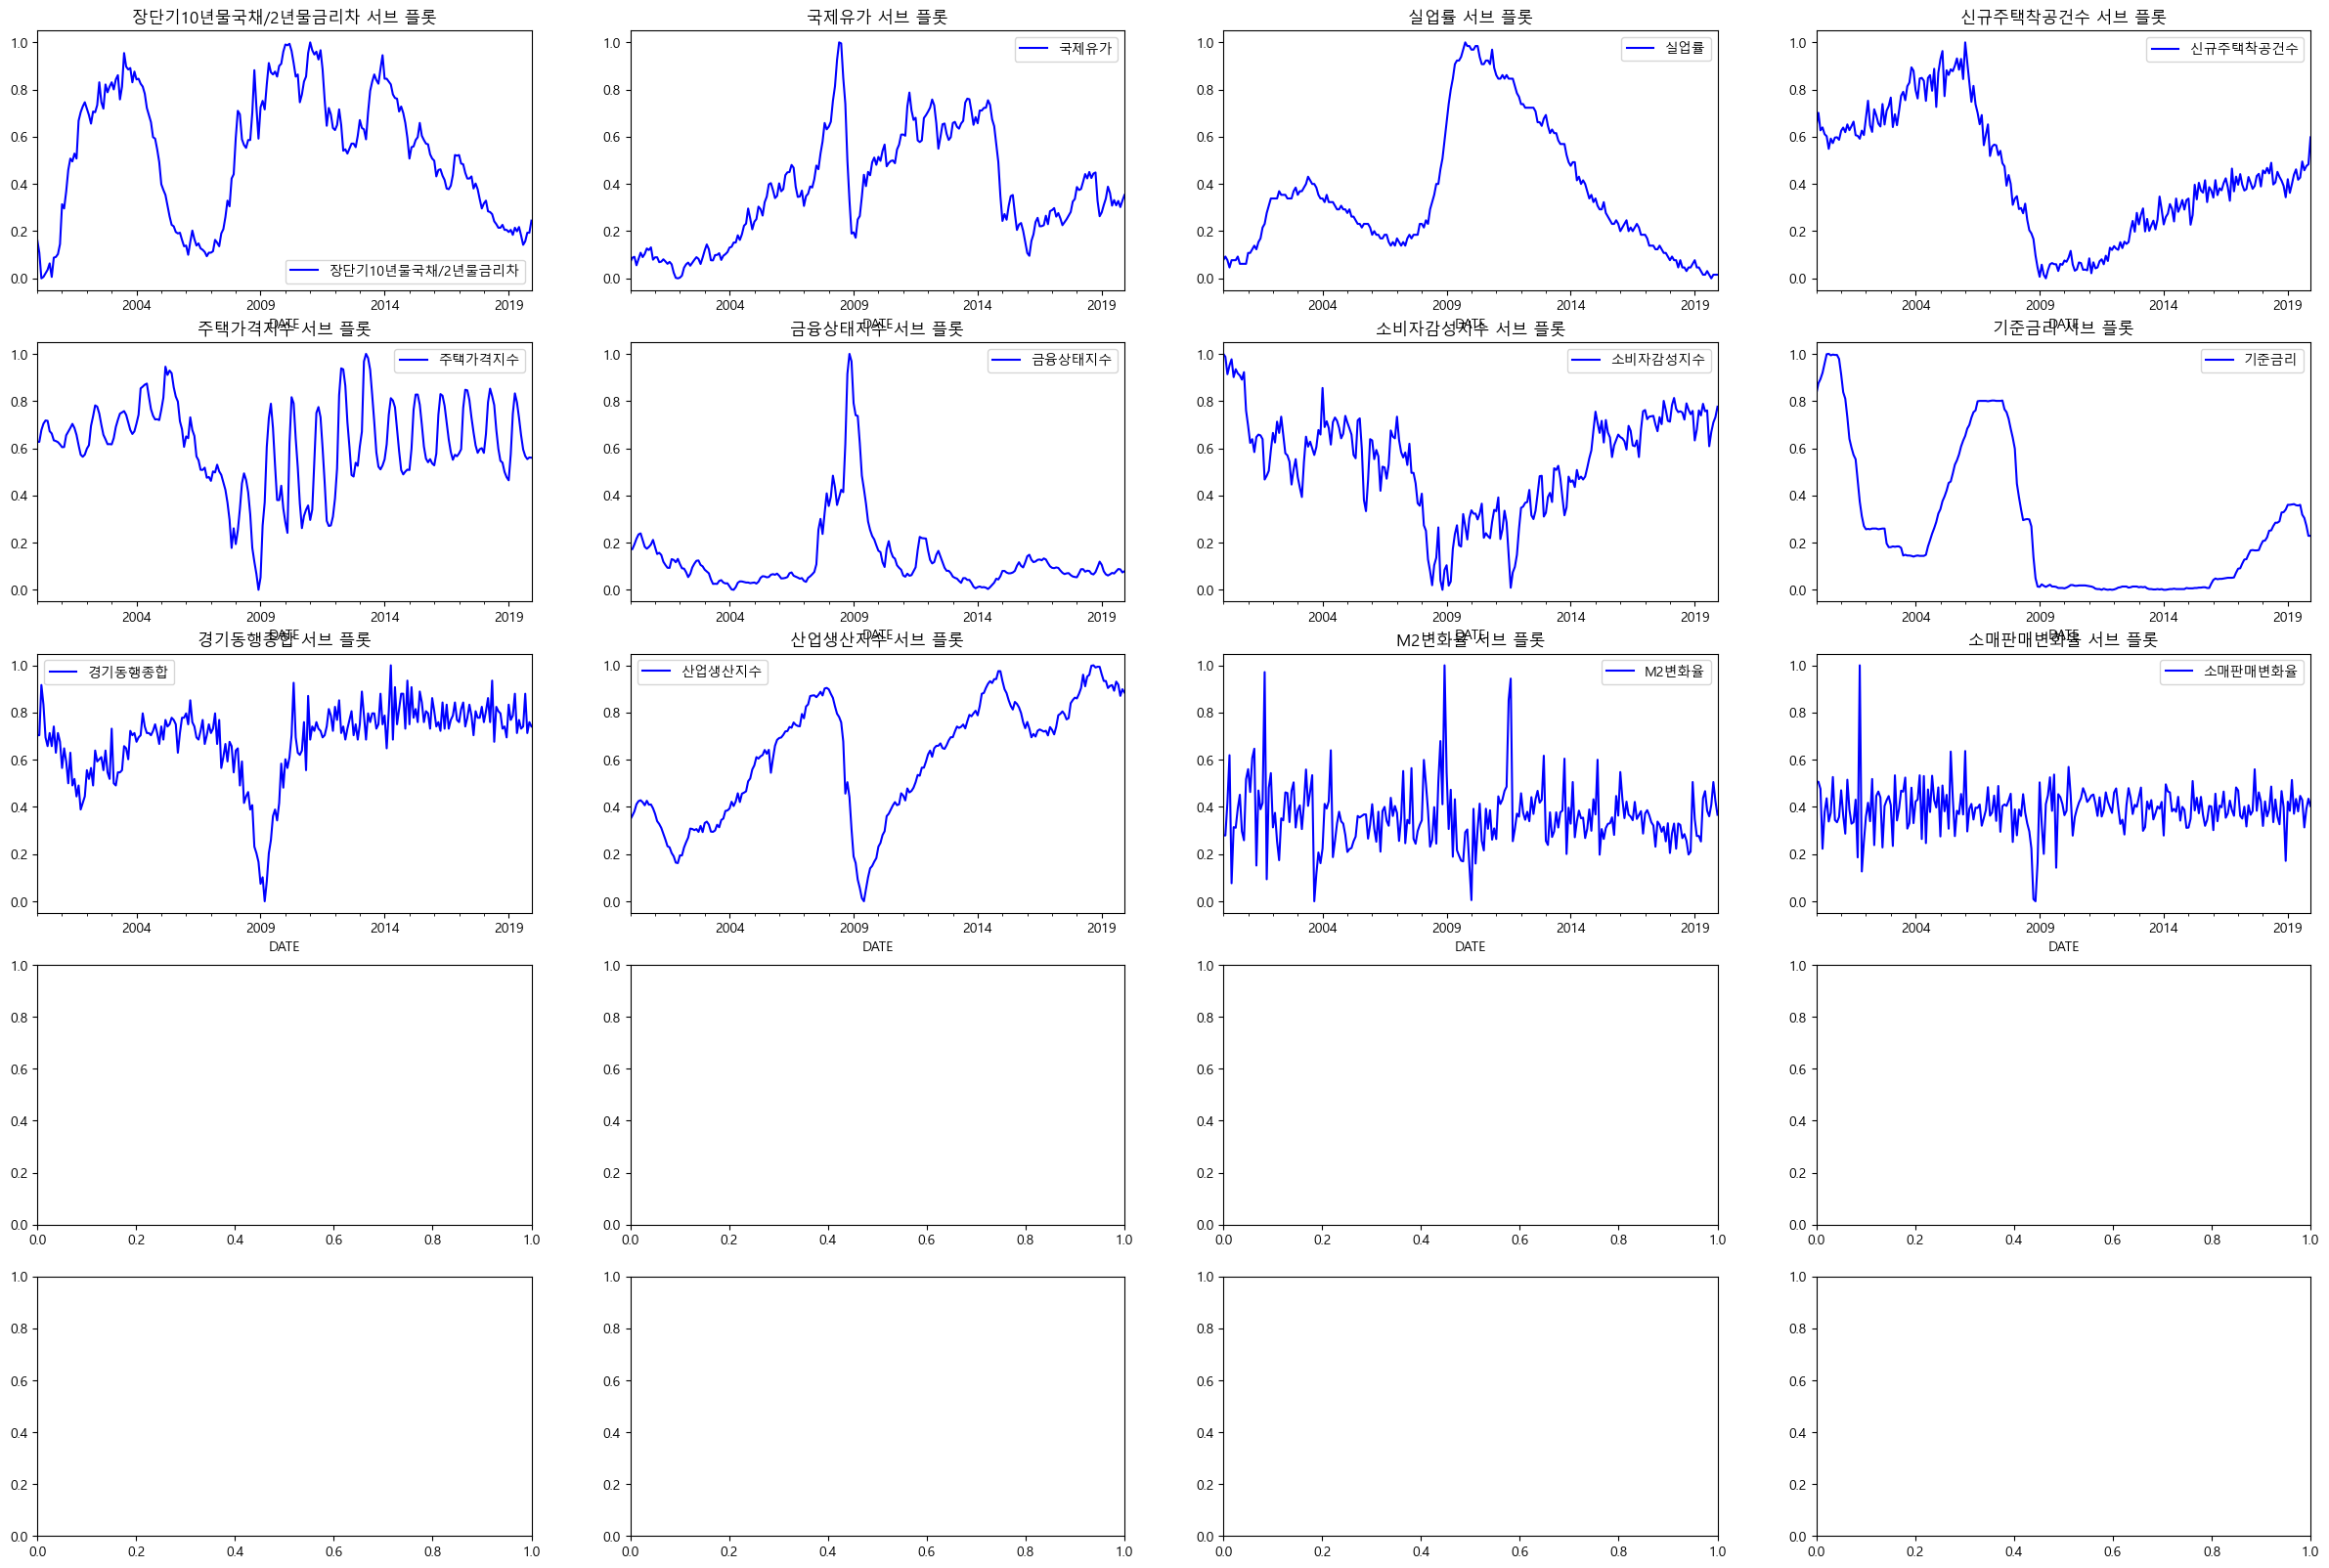

In [15]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(mMscaled_data.columns):
    mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D



### MeanShift

In [17]:
scale_2.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.65,0.63,0.18,1.00,0.83,0.70,0.35,0.28,0.51
2000-02-29,0.11,0.09,0.09,0.70,0.63,0.17,0.99,0.87,0.70,0.36,0.28,0.51
2000-03-31,0.00,0.09,0.08,0.63,0.68,0.19,0.91,0.89,0.92,0.38,0.42,0.48
2000-04-30,0.01,0.06,0.05,0.64,0.70,0.22,0.95,0.92,0.83,0.41,0.62,0.22
2000-05-31,0.02,0.08,0.08,0.61,0.72,0.23,0.98,0.96,0.69,0.42,0.08,0.38


In [18]:
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split

# X, y = train_test_split(mMscaled_data, test_size=0.3, random_state=0)


# Mean Shift
meanshift = MeanShift(bandwidth=0.7)
cluster_labels = meanshift.fit_predict(scale_2)
scale_2['cluster'] = cluster_labels

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2 3]


In [19]:
# 알고리즘 방법으로 대역폭 설정하는 방식 = 절대적인게 아니라서 적정히 활용

# # 대역폭에 따라 군집의 개수는 큰 영향을 받으므로 최적의 대역폭을 찾는 것이 중요하다.
# from sklearn.cluster import estimate_bandwidth

# bandwidth = estimate_bandwidth(mMscaled_data)
# print('bandwidth 값:', round(bandwidth,3))

In [20]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [21]:
scale_2.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster
DATE,,,,,,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.65,0.63,0.18,1.00,0.83,0.70,0.35,0.28,0.51,0
2000-02-29,0.11,0.09,0.09,0.70,0.63,0.17,0.99,0.87,0.70,0.36,0.28,0.51,0
2000-03-31,0.00,0.09,0.08,0.63,0.68,0.19,0.91,0.89,0.92,0.38,0.42,0.48,0
2000-04-30,0.01,0.06,0.05,0.64,0.70,0.22,0.95,0.92,0.83,0.41,0.62,0.22,0
2000-05-31,0.02,0.08,0.08,0.61,0.72,0.23,0.98,0.96,0.69,0.42,0.08,0.38,0


In [22]:
cluster0 = scale_2[scale_2['cluster']==0]
cluster1 = scale_2[scale_2['cluster']==1]
cluster2 = scale_2[scale_2['cluster']==2]
cluster3 = scale_2[scale_2['cluster']==3]

In [23]:
cluster0.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster
DATE,,,,,,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.65,0.63,0.18,1.00,0.83,0.70,0.35,0.28,0.51,0
2000-02-29,0.11,0.09,0.09,0.70,0.63,0.17,0.99,0.87,0.70,0.36,0.28,0.51,0
2000-03-31,0.00,0.09,0.08,0.63,0.68,0.19,0.91,0.89,0.92,0.38,0.42,0.48,0
2000-04-30,0.01,0.06,0.05,0.64,0.70,0.22,0.95,0.92,0.83,0.41,0.62,0.22,0
2000-05-31,0.02,0.08,0.08,0.61,0.72,0.23,0.98,0.96,0.69,0.42,0.08,0.38,0


In [24]:
scale_2['cluster'].value_counts().index

Index([0, 1, 2, 3], dtype='int64', name='cluster')

In [25]:
scale_2['cluster'].value_counts()

cluster
0    150
1     66
2     16
3      8
Name: count, dtype: int64

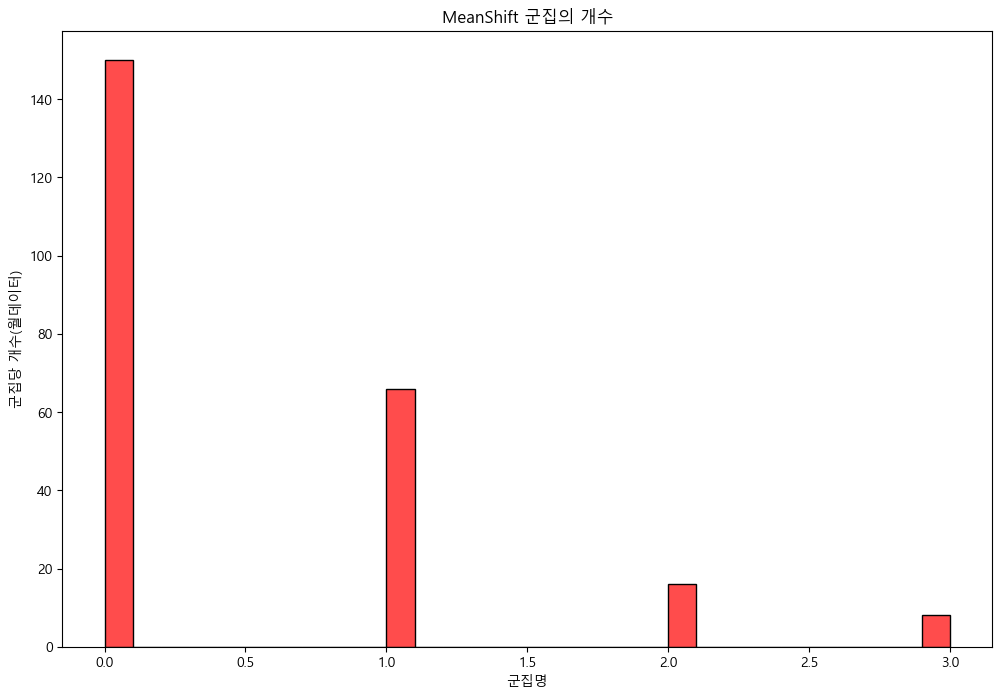

In [26]:
# menashift 군집화 결과를 시각화
import seaborn as sns
# Seaborn 히스토그램 그리기

a=  scale_2['cluster']
plt.figure(figsize=(12, 8))
# 무지개 색깔
sns.histplot(a, bins=30, color = 'red', edgecolor='black', alpha=0.7)
# 그래프 제목과 축 레이블 추가
plt.title('MeanShift 군집의 개수')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')

# 그래프 보이기
plt.show()

#### ANOVA

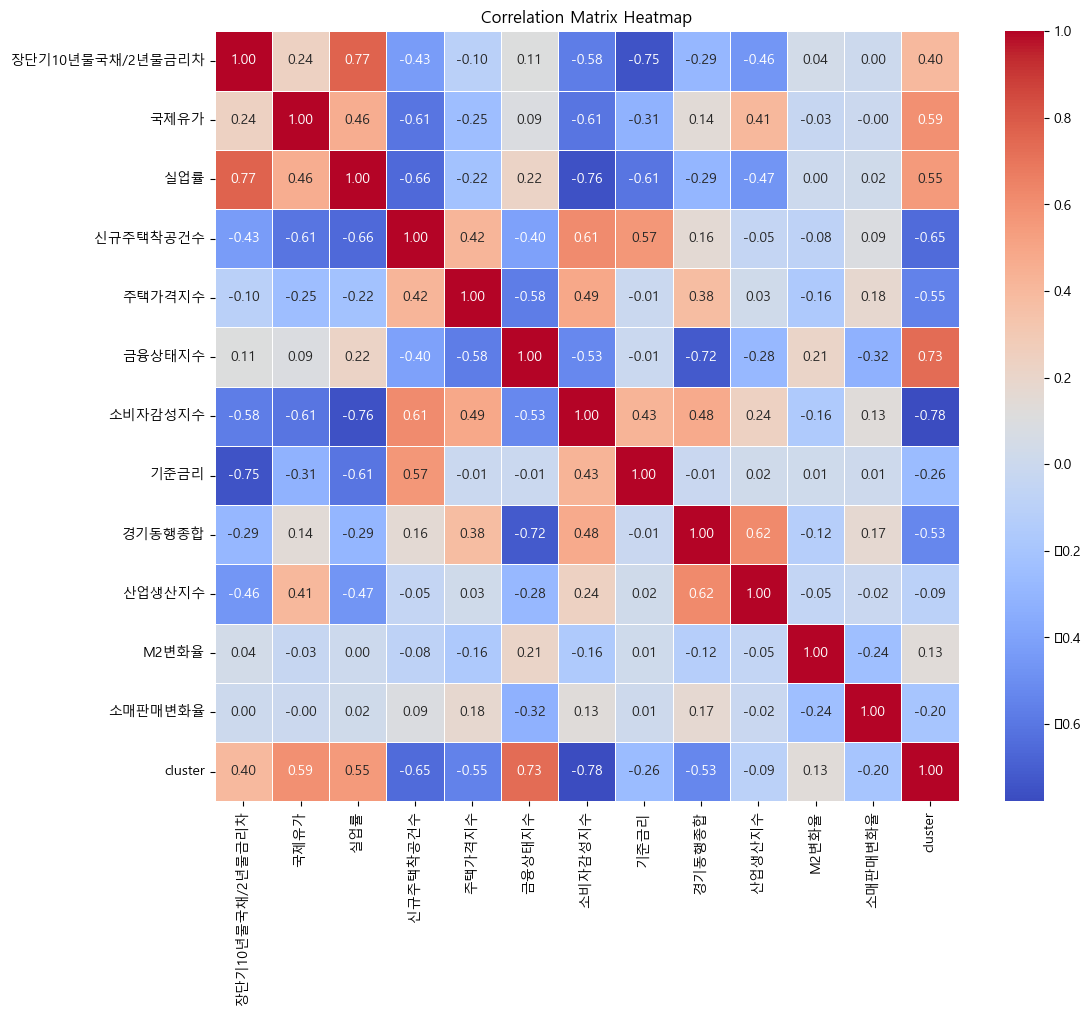

In [27]:
# 독립성 검정
import matplotlib.pyplot as plt
import seaborn as sns

# 상관 행렬 계산
correlation_matrix = scale_2[scale_2.columns].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [28]:
# 정규성 검정 (Shapiro-Wilk)
# 귀무가설 : 정규분포를 따른다
from scipy.stats import shapiro

# 클러스터별 feature에 대해 정규성 검정 수행
for cluster_num in range(4):  # 클러스터 번호는 0부터 3까지 총 4개
    cluster_data = scale_2[scale_2['cluster'] == cluster_num]
    
    print(f"\nCluster {cluster_num} - Shapiro-Wilk Test:")
    for column in cluster_data.columns:
        shapiro_test = shapiro(cluster_data[column])
        if shapiro_test.pvalue >= 0.05:
            print(f"{column} - p-value: {shapiro_test.pvalue}")


Cluster 0 - Shapiro-Wilk Test:
cluster - p-value: 1.0

Cluster 1 - Shapiro-Wilk Test:
소비자감성지수 - p-value: 0.4014822840690613
산업생산지수 - p-value: 0.061514053493738174
cluster - p-value: 1.0

Cluster 2 - Shapiro-Wilk Test:
장단기10년물국채/2년물금리차 - p-value: 0.0955938771367073
국제유가 - p-value: 0.5702031254768372
신규주택착공건수 - p-value: 0.8239440321922302
주택가격지수 - p-value: 0.13779497146606445
금융상태지수 - p-value: 0.4623136520385742
소비자감성지수 - p-value: 0.6157012581825256
경기동행종합 - p-value: 0.09744924306869507
M2변화율 - p-value: 0.060942210257053375
소매판매변화율 - p-value: 0.3218934237957001
cluster - p-value: 1.0

Cluster 3 - Shapiro-Wilk Test:
장단기10년물국채/2년물금리차 - p-value: 0.6477174758911133
국제유가 - p-value: 0.2291591614484787
실업률 - p-value: 0.7789458632469177
신규주택착공건수 - p-value: 0.16207635402679443
주택가격지수 - p-value: 0.2261231690645218
금융상태지수 - p-value: 0.732591450214386
소비자감성지수 - p-value: 0.3201393783092499
경기동행종합 - p-value: 0.5375657081604004
산업생산지수 - p-value: 0.4474232792854309
M2변화율 - p-value: 0.548891007900238
소매

In [29]:
# clust0이 데이터 수가 가장 많았지만 모든 데이터가 정규성을 만족하지 않음
# MeanShift(bandwidth=0.7)는 유의하지 않는 모델로 판단

In [30]:
# 등분산성 검정 - 레빈검정
# 귀무가설 : 등분산성의 특징이 있다
from scipy.stats import bartlett

# 등분산성 검정을 수행할 데이터프레임들
dataframes = [cluster0, cluster1, cluster2, cluster3, cluster4]

# 각 데이터프레임에 대해 등분산성 검정 수행
for i, cluster_data in enumerate(dataframes):
    print(f"\nCluster {i} - Bartlett's Test:")
    for column in cluster_data.columns:
        # 등분산성 검정 수행
        bartlett_test = bartlett(*[dataframe[column] for dataframe in dataframes])
        if bartlett_test.pvalue >= 0.05:
            print(f"{column} - p-value: {bartlett_test.pvalue}")

NameError: name 'cluster4' is not defined

ANOVA 수행

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.formula.api import ols

for col in cluster0.columns:
    F, p = stats.f_oneway(cluster0[col],
                    cluster1[col],
                    cluster2[col],
                    cluster3[col],
                    cluster4[col])
    # print(col)
    # print( 'F-Ratio: {}'.format(F)
    # , 'p-value:{}'.format(p)
    #  , sep = '\n')
    if p <= 0.05:
        print(f"{col} \n F-Ratio: {F} \n p-value: {p}")